<a href="https://colab.research.google.com/github/ermaury/k_brazos_AM_DE_JP/blob/main/P1/bandit_experiment_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos Softmax y Gradiente de preferencias en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Luis Daniel Hernández Molinero
    Email: ldaniel@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [1]:
import os
import sys

# Comprobar si estamos en Google Colab
try:
    import google.colab
    EN_COLAB = True
except ImportError:
    EN_COLAB = False

if EN_COLAB:
    # Descargar el repositorio
    !git clone https://github.com/ermaury/k_brazos_AM_DE_JP.git

    # Cambiar al directorio de trabajo donde está P1
    repo_path = '/content/k_brazos_AM_DE_JP/P1'
    os.chdir(repo_path)

    # Confirmar cambio de directorio y añadir al path
    print("Directorio actual:", os.getcwd())
    sys.path.append(repo_path)

In [2]:
import numpy as np
from typing import List

from algorithms import Algorithm, GradientBandit, SoftmaxBandit
from arms import ArmNormal, ArmBernouilli, ArmBinomial, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics


semilla = 43

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [3]:
def run_experiment(bandit, algorithms: List, steps: int, runs: int):
    """
    Ejecuta experimentos con múltiples algoritmos sobre un bandit dado.

    :param bandit: Instancia de la clase Bandit.
    :param algorithms: Lista de instancias de algoritmos a evaluar.
    :param steps: Número de pasos de tiempo a simular.
    :param runs: Número de ejecuciones para promediar los resultados.
    
    :return: rewards, optimal_selections, regret_accumulated, arm_stats - 
             Matrices con recompensas, selecciones óptimas, regret acumulado y estadísticas de brazos.
    """

    np.random.seed(semilla)  # Asegurar reproducibilidad
    
    optimal_arm = bandit.optimal_arm  # Índice del brazo óptimo
    optimal_reward = bandit.expected_rewards[optimal_arm]  # Recompensa esperada del brazo óptimo
    num_arms = len(bandit.arms)  # Número total de brazos

    rewards = np.zeros((len(algorithms), steps))  # Matriz para recompensas promedio
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para selecciones óptimas
    regrets = np.zeros((len(algorithms), steps))  # Matriz para regret acumulado

    # Inicializar estadísticas de cada brazo por algoritmo
    arm_stats = [
        {
            'total_rewards': np.zeros(num_arms),  # Suma de recompensas por brazo
            'selections': np.zeros(num_arms),    # Veces que se seleccionó cada brazo
            'optimal_arm': optimal_arm,          # Guardar cuál es el brazo óptimo
        }
        for _ in range(len(algorithms))
    ]

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)  # Nueva instancia del bandit

        # Reiniciar los algoritmos
        for algo in algorithms:
            algo.reset()

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener recompensa
                algo.update(chosen_arm, reward)  # Actualizar valores estimados

                rewards[idx, step] += reward  # Acumular recompensa

                # Si el brazo elegido es el óptimo, incrementar el contador
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del regret instantáneo
                regret = optimal_reward - reward
                regrets[idx, step] += regret

                # Guardar estadísticas del brazo seleccionado
                arm_stats[idx]['total_rewards'][chosen_arm] += reward
                arm_stats[idx]['selections'][chosen_arm] += 1

    # Promediar los valores sobre el número de ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje
    regrets /= runs  # Promediar regret acumulado

    # Calcular promedio de recompensas por brazo
    for idx in range(len(algorithms)):
        # Evitar divisiones por cero (si un brazo no fue seleccionado)
        mask = arm_stats[idx]['selections'] > 0
        arm_stats[idx]['avg_rewards'] = np.zeros(num_arms)
        arm_stats[idx]['avg_rewards'][mask] = arm_stats[idx]['total_rewards'][mask] / arm_stats[idx]['selections'][mask]
        
    return rewards, optimal_selections, regrets, arm_stats

## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos de ``GradientBandit`` para valores ``alpha = 0.01``, ``0.05``, y ``0.1`` y 3 algoritmos ``SoftmaxBandit`` con ``tau = 0.01``, ``tau = 0.5`` y ``tau = 1.0``.

In [4]:
# Parámetros del experimento
np.random.seed(semilla)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

arms = [ArmNormal, ArmBernouilli, ArmBinomial]

# Creación del bandit
bandits = [Bandit(arms=arm.generate_arms(k)) for arm in arms]

results = dict()

for bandit in bandits:
    print(f"Executing Bandit with arm type {bandit.get_type_arms()}")
    
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")
    
    # Definir los algoritmos a comparar. En este caso son 3 algoritmos SoftmaxBandit con diferentes valores de parametro tau y 3 algoritmos GradientBandit con distintos parametros alpha.
    algorithms = [SoftmaxBandit(k=k, tau=0.01), SoftmaxBandit(k=k, tau=0.5), SoftmaxBandit(k=k, tau=1.0), GradientBandit(k=k, alpha=0.01), GradientBandit(k=k, alpha=0.05), GradientBandit(k=k, alpha=0.1)]
    
    # Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
    rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps=1000, runs=500)

    results[bandit.get_type_arms()] = (rewards, optimal_selections, regret_accumulated, arm_stats)


    # Calcular la recompensa media total para cada algoritmo
    mean_rewards = rewards.mean(axis=1)

    print("\nRecompensas medias por algoritmo:")
    for algo, mean_reward in zip(algorithms, mean_rewards):
        print(f"{algo.get_algorithm_label()}: {mean_reward:.3f}")
    print("\n" + "-"*50)

Executing Bandit with arm type ArmNormal
Optimal arm: 8 with expected reward=8.73

Recompensas medias por algoritmo:
SoftmaxBandit (tau=0.01): 4.957
SoftmaxBandit (tau=0.5): 6.845
SoftmaxBandit (tau=1.0): 7.616
GradientBandit (alpha=0.01, baseline=True): 7.361
GradientBandit (alpha=0.05, baseline=True): 8.336
GradientBandit (alpha=0.1, baseline=True): 8.415

--------------------------------------------------
Executing Bandit with arm type ArmBernouilli
Optimal arm: 5 with expected reward=0.8666486408992002

Recompensas medias por algoritmo:
SoftmaxBandit (tau=0.01): 0.629
SoftmaxBandit (tau=0.5): 0.601
SoftmaxBandit (tau=1.0): 0.512
GradientBandit (alpha=0.01, baseline=True): 0.468
GradientBandit (alpha=0.05, baseline=True): 0.640
GradientBandit (alpha=0.1, baseline=True): 0.729

--------------------------------------------------
Executing Bandit with arm type ArmBinomial
Optimal arm: 10 with expected reward=11.738449608984073

Recompensas medias por algoritmo:
SoftmaxBandit (tau=0.01)

In [5]:
rewards_normal, optimal_selections_normal, regret_accumulated_normal, arm_stats_normal = results['ArmNormal']
rewards_bernouilli, optimal_selections_bernouilli, regret_accumulated_bernouilli, arm_stats_bernouilli = results['ArmBernouilli']
rewards_binomial, optimal_selections_binomial, regret_accumulated_binomial, arm_stats_binomial = results['ArmBinomial']

## Visualización de los resultados (Brazo Normal)

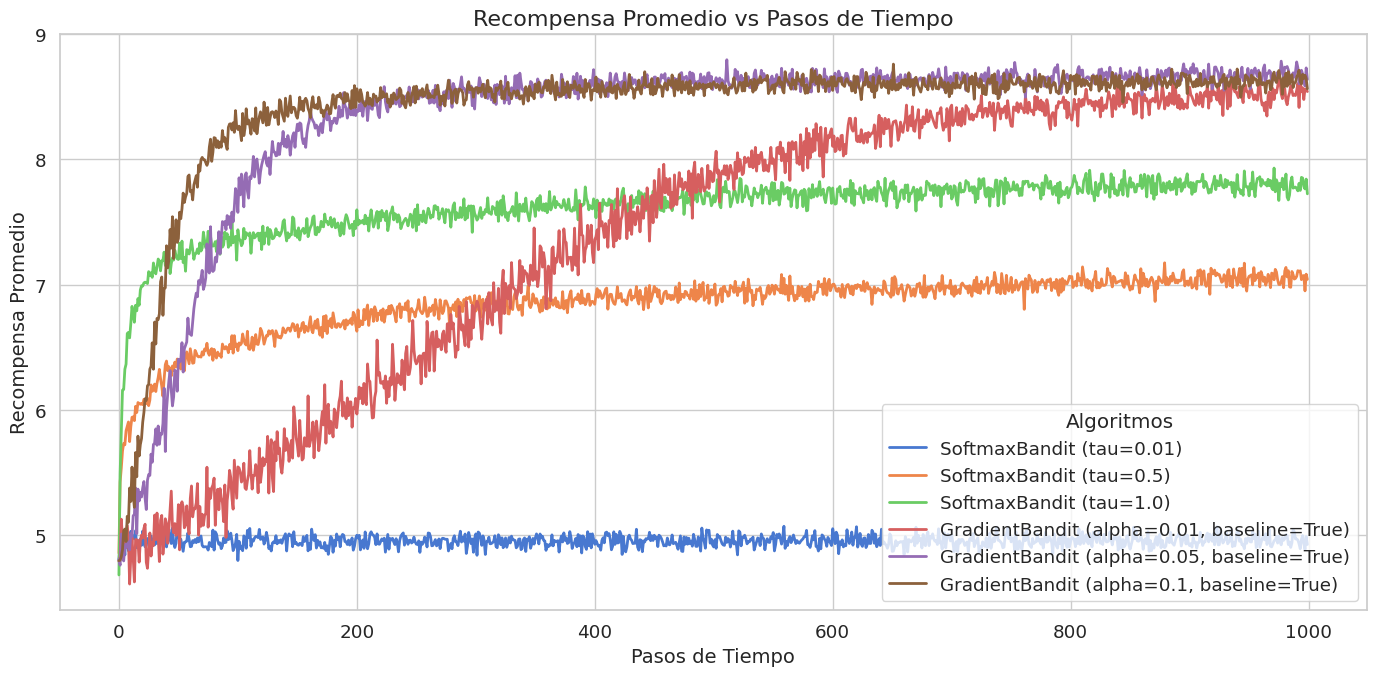

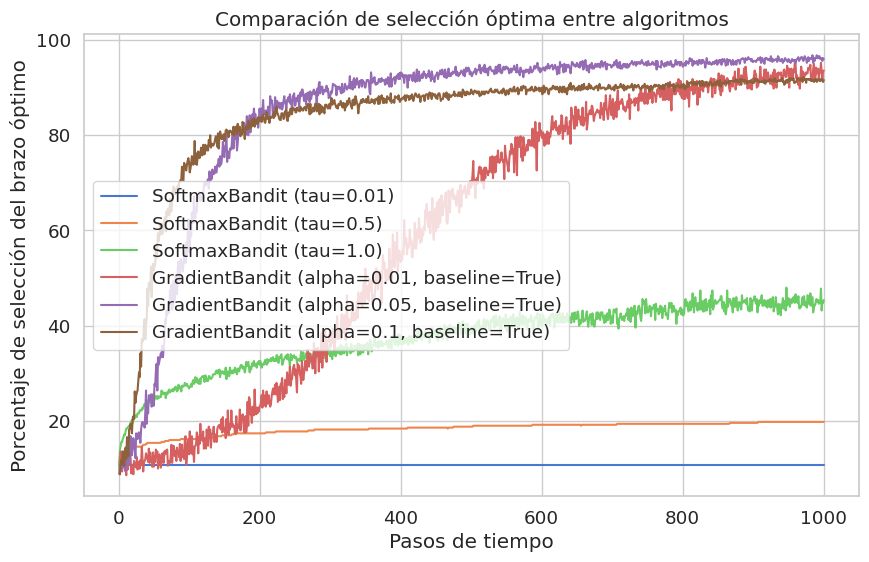

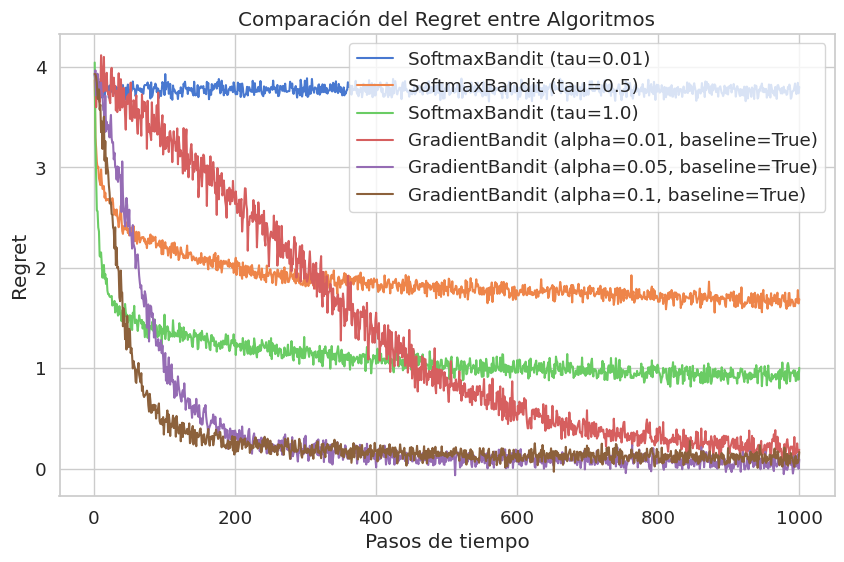

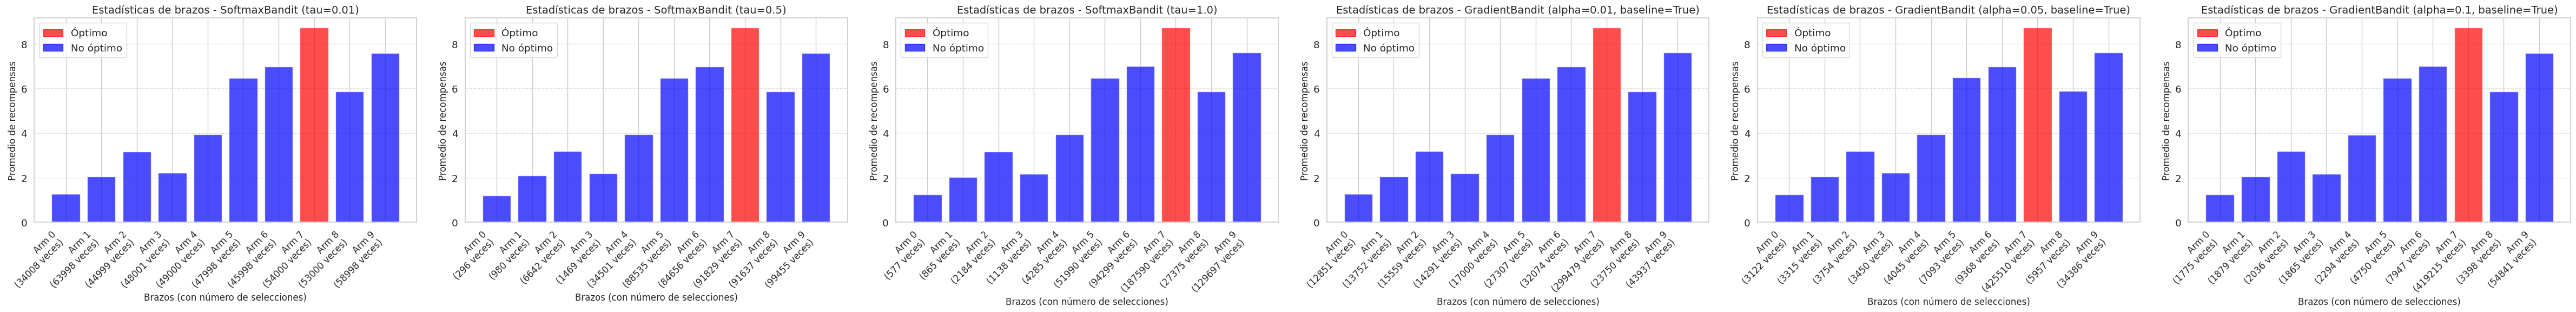

In [6]:
# Graficar los resultados
plot_average_rewards(steps, rewards_normal, algorithms)
plot_optimal_selections(steps, optimal_selections_normal, algorithms)
plot_regret(steps, regret_accumulated_normal, algorithms)
plot_arm_statistics(arm_stats_normal, algorithms)


### Comparación de Recompensa Promedio

- **SoftmaxBandit con τ = 0.01** muestra un rendimiento deficiente. Apenas explora y converge rápidamente a una estrategia subóptima, con una recompensa promedio estable alrededor de 5.
- **SoftmaxBandit con τ = 0.5 y τ = 1.0** exploran más y logran converger a una recompensa promedio algo mejor (pero subóptima).
- **GradientBandit** con distintos valores de α:
  - α = 0.01: presenta una evolución más lenta pero constante, convergiendo con precisión al óptimo.
  - α = 0.05 y 0.1: alcanzan buena recompensa promedio más rápidamente, aunque con algo más de variabilidad al inicio.

### Comparación de Selección del Brazo Óptimo

- **SoftmaxBandit con ``τ = 0.01``** selecciona el brazo óptimo con muy poca frecuencia (~10%), evidenciando falta de exploración.
- Con **``τ = 0.5`` y ``τ = 1.0``**, el porcentaje de selección óptima alcanza el 20% y 40% respectivamente tras 1000 pasos.
- **GradientBandit** con ``α = 0.05`` y ``0.1`` superan el 80% (``α = 0.05`` incluso supera el 90%), mientras que ``α = 0.01`` tarda más en estabilizarse pero lo consigue.

### Comparación del Regret

- El **regret más bajo** lo alcanzan `GradientBandit (α = 0.1)` y `GradientBandit (α = 0.05)`, lo que indica una convergencia rápida y sostenida hacia el brazo óptimo.
- `SoftmaxBandit (τ = 0.01)` mantiene un regret constante debido a la falta de aprendizaje efectivo.
- El resto de configuraciones muestran una progresiva disminución del regret, con valores cercanos a cero al final del horizonte temporal en el caso de ``GrandientBandit``.

### Estadísticas de los Brazos

- Las gráficas de estadísticas muestran que:
  - Los algoritmos `Softmax τ = 1.0`, `GradientBandit α = 0.05 y 0.1` asignan la mayoría de las selecciones al brazo óptimo.
  - `SoftmaxBandit (τ = 0.01)` distribuye las selecciones de forma más dispersa y subóptima, sin concentrarse en el mejor brazo.

### Conclusión

Se puede apreciar una fuerte diferencia entre ambos algoritmos, siendo más efectivo ``GradientBandit``.


## Visualización de los resultados (Brazo Bernoulli)

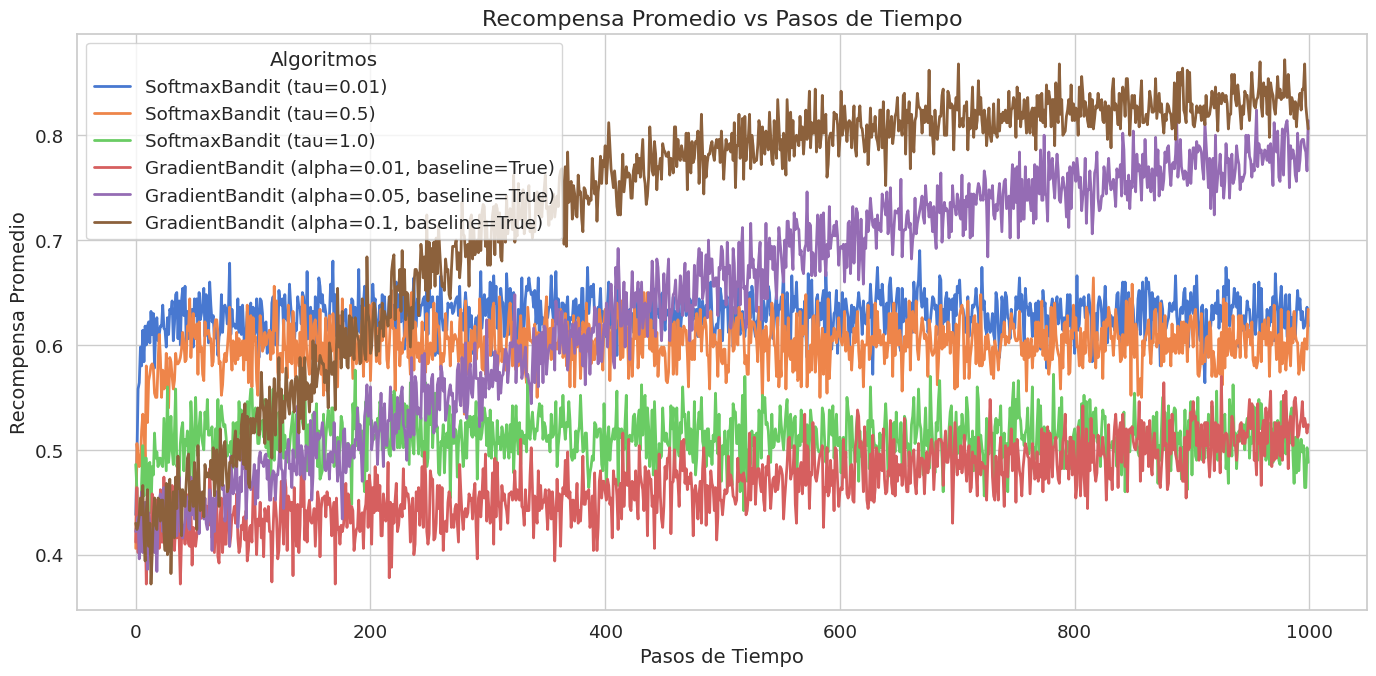

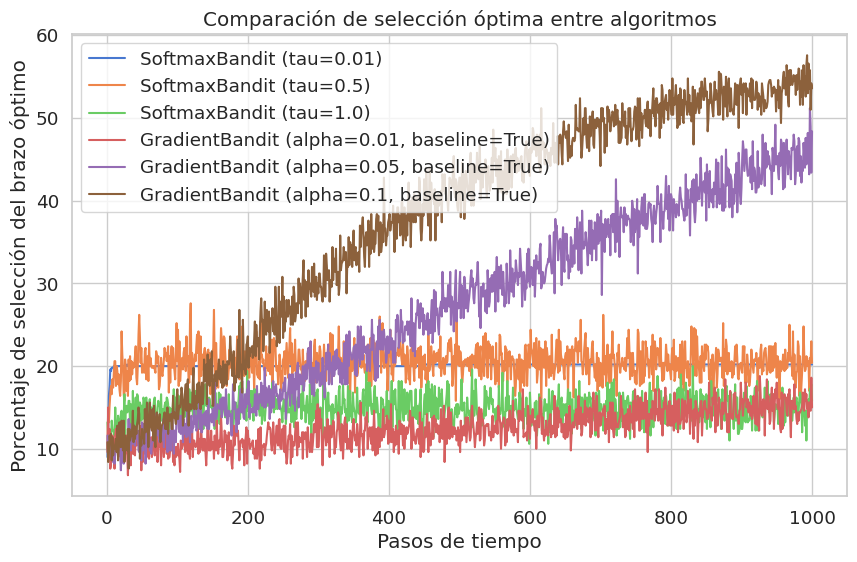

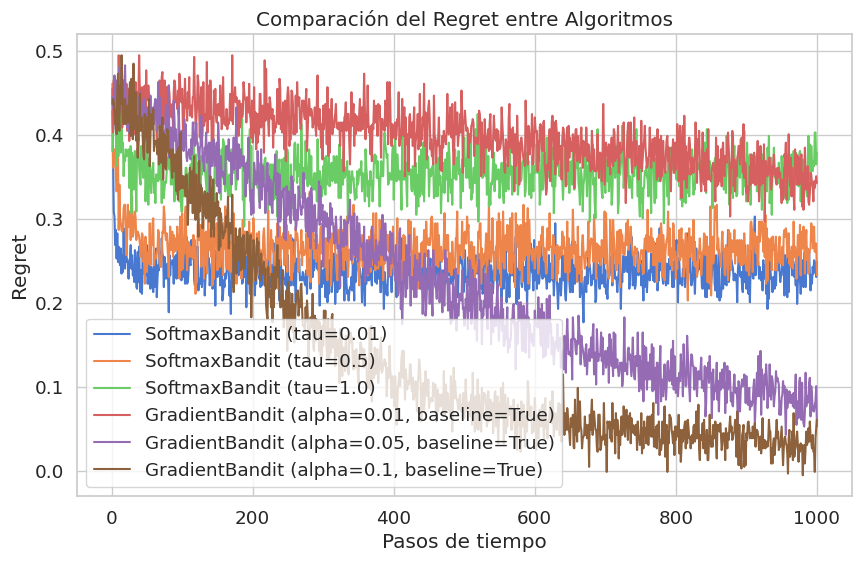

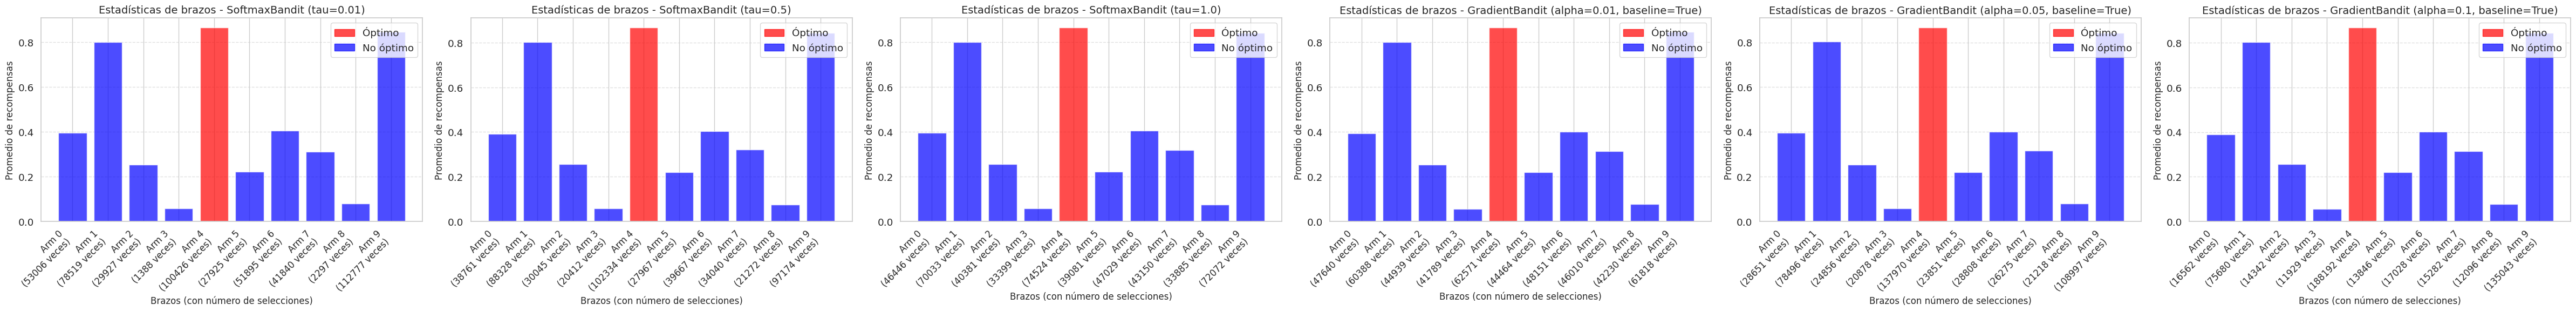

In [7]:
# Graficar los resultados
plot_average_rewards(steps, rewards_bernouilli, algorithms)
plot_optimal_selections(steps, optimal_selections_bernouilli, algorithms)
plot_regret(steps, regret_accumulated_bernouilli, algorithms)
plot_arm_statistics(arm_stats_bernouilli, algorithms)

### Comparación de Recompensa Promedio

- **SoftmaxBandit con τ = 0.01** comienza con buena recompensa promedio (≈0.65) pero se estabiliza rápidamente sin mejorar, indicando poca exploración.
- **SoftmaxBandit con τ = 0.5 y τ = 1.0** exploran más, pero no consiguen superar al caso más explotador, indicativo de que quizás este ha tenido suerte al encontrar el óptimo (u brazos cercanos al óptimo).
- **GradientBandit**:
  - **α = 0.01** tiene un rendimiento bajo, avanzando lentamente hacia recompensas aceptables (~0.5).
  - **α = 0.05** muestra mejoras constantes y sostenidas, alcanzando valores cercanos a los de Softmax con τ = 1.0.
  - **α = 0.1** mejora más y más rápido.

### Comparación de Selección del Brazo Óptimo

- **SoftmaxBandit (``τ = 0.01`` y ``τ = 0.5``)** se estancan en ~20% de selección óptima.
- **SoftmaxBandit (``τ = 1.0``)** alcanza entre el 15% de selección del brazo óptimo, indicando que no ha conseguido explorar lo suficiente para detectar con claridad al óptimo.
- **GradientBandit con ``α = 0.1``** alcanza el mejor porcentaje (50%) de forma rápida, seguido de GradientBandit (``α = 0.05``) con un 45%.
- **GradientBandit (``α = 0.01``)** tiene dificultades claras para identificar el brazo óptimo en este entorno.

### Comparación del Regret

- **GradientBandit (α = 0.1)** y **GradientBandit (α = 0.05)** alcanzan los mejores valores de regret.
- El resto de algoritmos acumulan más regret y se estabilizan en ese rango (signo de no haber encontrado de forma clara el óptimo)

### Estadísticas de los Brazos

- **GradientBandit con ``α = 0.1``** asigna la mayoría de selecciones al brazo óptimo, seguido por **GradientBandit (α = 0.05)**.
- Los algoritmos con parámetros mal ajustados (como **τ = 0.01** y **α = 0.01**) reparten más las selecciones entre brazos subóptimos.

### Conclusión

En entornos donde es dificil de detectar el brazo óptimo, podemos observar como el rendimiento de ambos algoritmos decrece de forma clara frente a los de epsilon-greedy y UCB (Upper Confidence Bound).

## Visualización de los resultados (Brazo distribución Binomial)

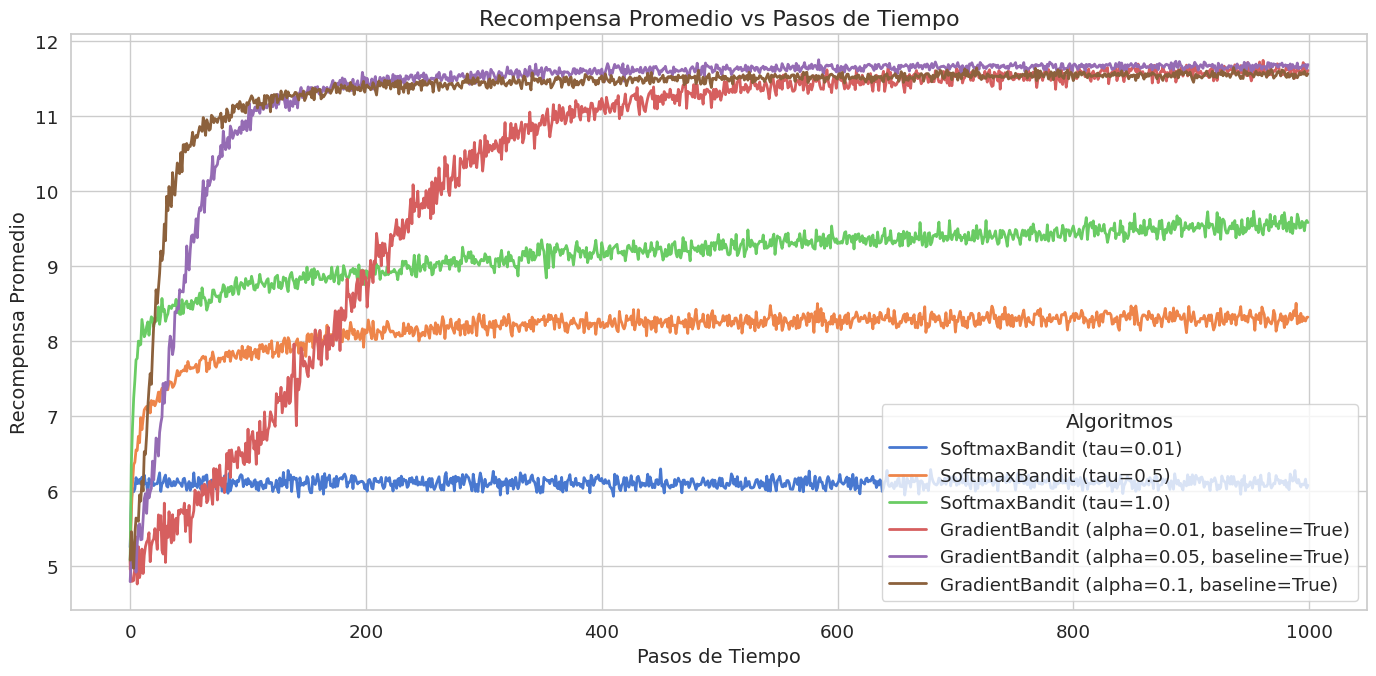

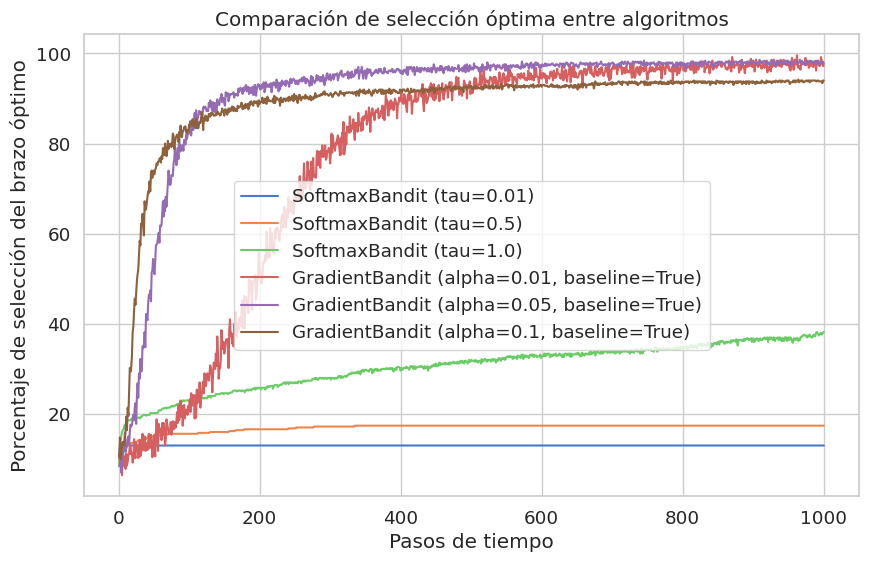

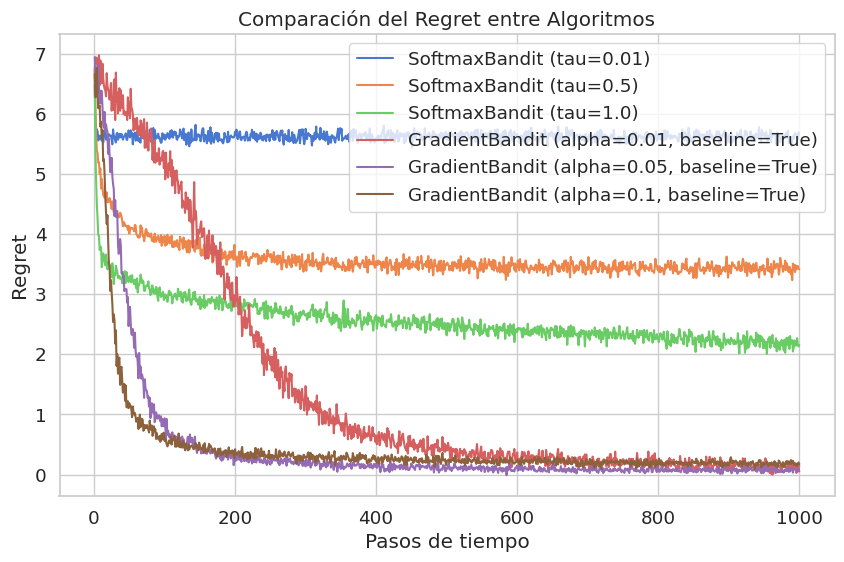

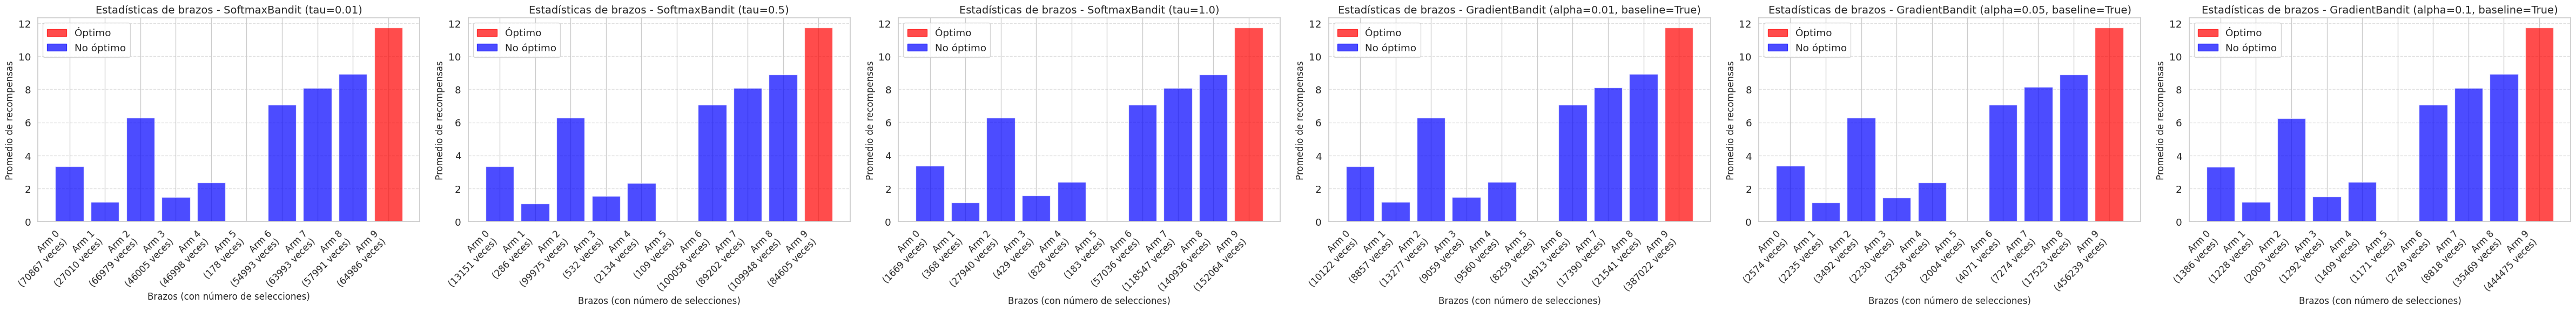

In [8]:
# Graficar los resultados
plot_average_rewards(steps, rewards_binomial, algorithms)
plot_optimal_selections(steps, optimal_selections_binomial, algorithms)
plot_regret(steps, regret_accumulated_binomial, algorithms)
plot_arm_statistics(arm_stats_binomial, algorithms)

### Recompensa Promedio

La recompensa promedio permite evaluar la eficiencia global del algoritmo a lo largo del tiempo:

- **SoftmaxBandit con `tau=0.01`** muestra una rápida estabilización, pero se queda lejos del óptimo. La baja temperatura produce una política demasiado conservadora (cercana a la explotación).
- **SoftmaxBandit con `tau=0.5` y `tau=1.0`** presentan mejoras significativas, alcanzando mejores valores (similar al caso del brazo normal), pero sin llegar al óptimo.
- **GradientBandit con baseline (`alpha=0.05` y `alpha=0.1`)** logran las mejores recompensas promedio, convergiendo rápidamente y con poca oscilación. `alpha=0.1` obtiene una ventaja en la rapidez inicial.
- **GradientBandit con `alpha=0.01`** mejora progresivamente, pero a un ritmo más lento.

### Porcentaje de Selección del Brazo Óptimo

Este indicador mide con qué frecuencia el algoritmo identifica y selecciona el brazo óptimo:

- **SoftmaxBandit con (`tau=0.5` y `tau=1.0`)** alcanzan cerca del 20% y 40% respectivamente de selección óptima tras varias centenas de pasos.
- **GradientBandit con baseline y `alpha=0.01` y `alpha=0.05`** alcanzan el casi el 100% de selección del brazo óptimo, aunque `alpha=0.05` lo alcanza mucho antes.
- **SoftmaxBandit con (`tau=0.01` y `tau=0.5`)** se quedan notablemente por debajo (especialmente `tau=0.01`), con dificultades para explorar suficientemente.

### Regret

El regret mide la pérdida acumulada por no elegir siempre el brazo óptimo:

- **Softmax con `tau=0.01`** acumula el mayor regret, debido a su baja exploración.
- **GradientBandit (`alpha=0.05` y `alpha=0.1`)** presentan los menores valores de regret a lo largo de los 1000 pasos.
- **Softmax (`tau=0.5` y `tau=1.0`)** logran resultados intermedios.
- **GradientBandit con `alpha=0.01`** mejora lentamente, y por ello su regret es algo más elevado.

### Estadísticas de Brazos

- Los histogramas confirman las observaciones previas:
  - **Softmax con `tau=0.01`, `tau=0.5` y `tau=1.0`** concentran demasiadas selecciones en brazos subóptimos.
  - **GradientBandit (`alpha=0.01`, `alpha=0.05` y `alpha=0.1`)** muestran una clara preferencia por el brazo óptimo.
  - **GradientBandit con `alpha=0.01`** distribuye las selecciones más uniformemente, reflejo de su lento aprendizaje.

---

### Conclusión

En el entorno con distribución **binomial**, el algoritmo **GradientBandit con baseline y tasas de aprendizaje entre `0.05` y `0.1`** resulta ser el más eficiente y consistente, el método **Softmax** está muy por debajo. En cambio, los valores demasiado bajos de `tau` o `alpha` provocan una exploración insuficiente que perjudica el rendimiento global.


## Conclusión general

Se observó que el algoritmo Gradient Bandit, al operar directamente sobre las preferencias $H(a)$ y ajustar las probabilidades de forma implícita vía softmax, es menos sensible al ruido estocástico que las actualizaciones directas de estimación de recompensa utilizadas en Softmax.

Los gráficos de porcentaje de selección óptima evidencian que Gradient Bandit tiende a superar progresivamente a Softmax en las tres configuraciones de distribucióa.

En términos de regret acumulado, Gradient Bandit demostró el crecimiento más lento del rechazo, confirmando su mayor eficiencia en converger hacia el mejor brazo en un número reducido de pasos.

Estas observaciones refuerzan el potencial de los métodos de gradiente directo cuando se dispone de suficiente exploración inicial y una adecuada elección de tasa de aprendizaje.
